In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

# import gridtools.solps_python_scripts.setup
# from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *

import general.plotstyle


from gridtools.solps_python_scripts.read_ft46 import read_ft46
from gridtools.solps_python_scripts.plot_solps import plot_2d

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

SOLEDGE could not be imported
Viewer_2D: SOLEDGE functions not found
Done


## Read Hermes-3

In [2]:
db = CaseDB(
    case_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\cases",
    grid_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid"
)

toload = [ 
    # dict(name="fit_albedo", id="m7a-base_from_m6c--BASELINE1A", unnormalise_geom = True, use_xhermes = True, squash = True), 
    #  dict(name="fit_albedo_noFcx", id="m8b-noFcx_baseline_fix_7pcC--BASELINE1C", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="fit_puff", id="m9a-albedo_0.999_tunepuff--BASELINE2A", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="Baseline 2", id="m9ab-lo_Rc", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="Divertor pump: 9.7e21s-1", id="m9ad-lo_Rc_corr_neutalb_divpump", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="Divertor pump: 3.0e21s-1", id="m9adb-lo_Rc_corr_neutalb_divpump_-3e21", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="tune_neutalb", id="m9ac-lo_Rc_tune_neutalb", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="divpump", id="m9ad-lo_Rc_corr_neutalb_divpump", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case m9ab-lo_Rc
-----------------------
- Looking for squash file
- Squash file found. squash date 03/03/2025, 14:58:46, dmp file date 03/03/2025, 11:26:34

Unnormalising with xHermes
- Reading case m9ad-lo_Rc_corr_neutalb_divpump
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

Unnormalising with xHermes
- Reading case m9adb-lo_Rc_corr_neutalb_divpump_-3e21
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

Unnormalising with xHermes


In [3]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    # ds = ds.extract_2d_tokamak_geometry()
    # ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    # ds = reverse_pfr_fluxes(ds)

Baseline 2
Divertor pump: 9.7e21s-1
Divertor pump: 3.0e21s-1


## Read SOLPS

In [4]:
balance_paths = {
    "base" : r"C:\Users\Mike\OneDrive\Project\lot2_2d\Moulton MAST-U SOLPS runs\45456-Dec1523-seq-23\puff=1.5e21_pump=0.001_nodrifts_bcmom2_parmvsa2_redoutpfrtrans",
}

sp = dict()
store_slc = dict()

for name in balance_paths:
    store_slc[name] = SOLPScase(balance_paths[name])
    store_slc[name].get_species()
    store_slc[name].get_impurity_stats("C", all_states = True)
    
    sp[name] = SOLPSdata()
    sp[name].read_from_case(balance_paths[name])

Saving all states
Added total radiation, density and fraction for C


# Convergence

## Profiles

C:\Users\Mike\AppData\Local\Temp\ipykernel_12224\2646662622.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\plotting.py:756: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106


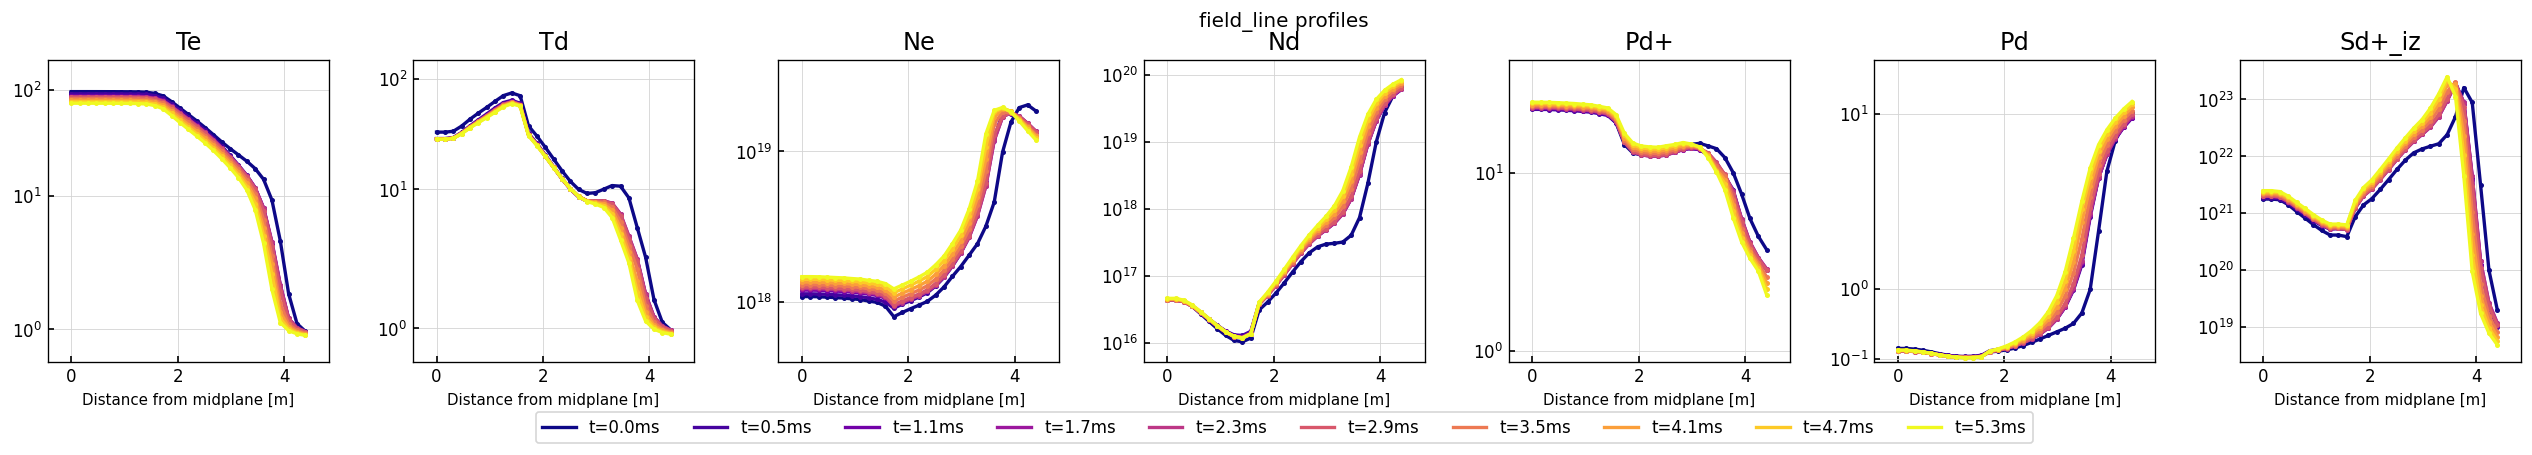

In [5]:
ds = cs["next-base"].ds

tlen = len(ds.coords["t"])
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]

toplot = {}
for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t)
    
lineplot(
        toplot,
        clean_guards = True,
        params = ["Te", "Td", "Ne", "Nd", "Pd+", "Pd", "Sd+_iz"],
        # params = ["dv"],
        # regions = ["omp", "outer_lower", "field_line"],
        regions = ["field_line"],
        colors = colors,
    )

# SOLPS comparison - baseline 1

In [5]:
cs.keys()

dict_keys(['Baseline 2', 'Divertor pump: 9.7e21s-1', 'Divertor pump: 3.0e21s-1'])

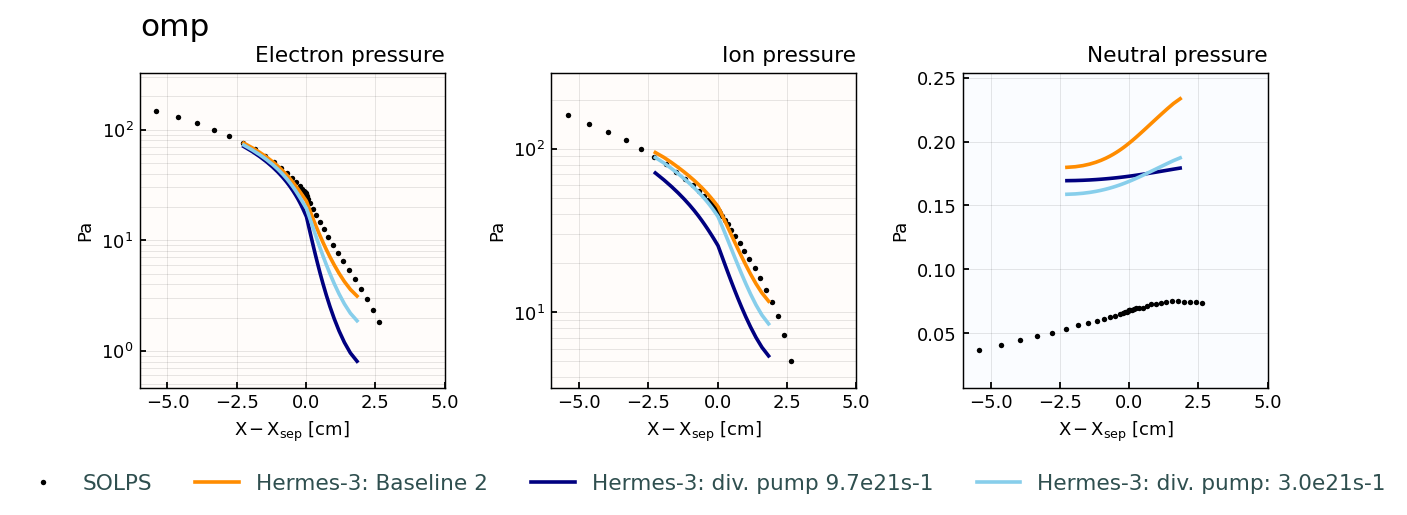

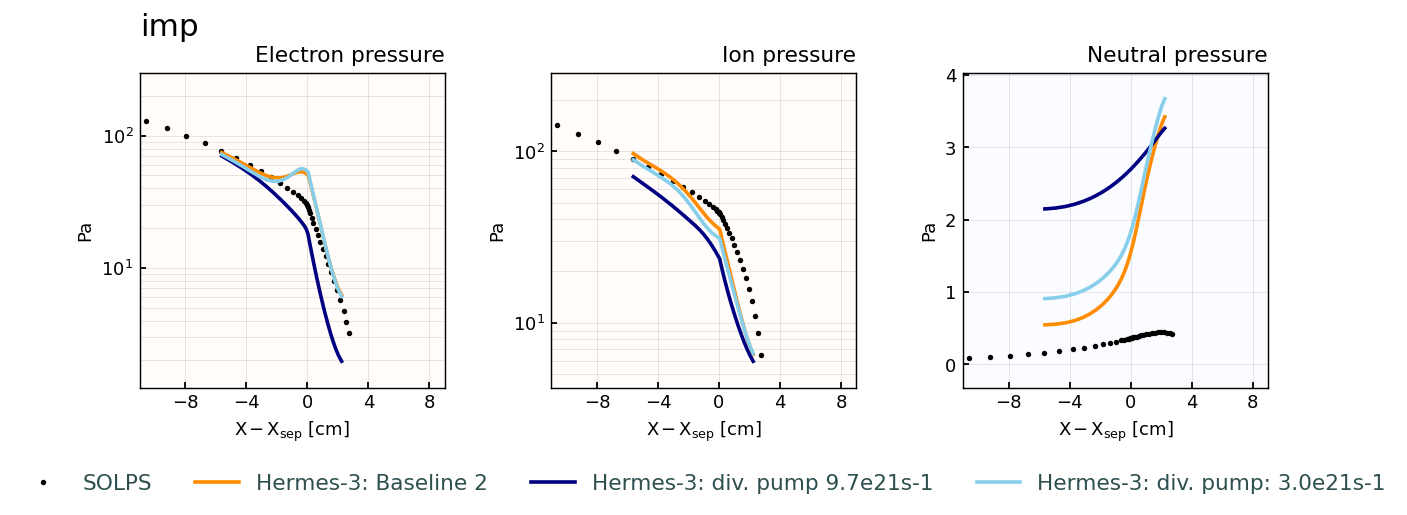

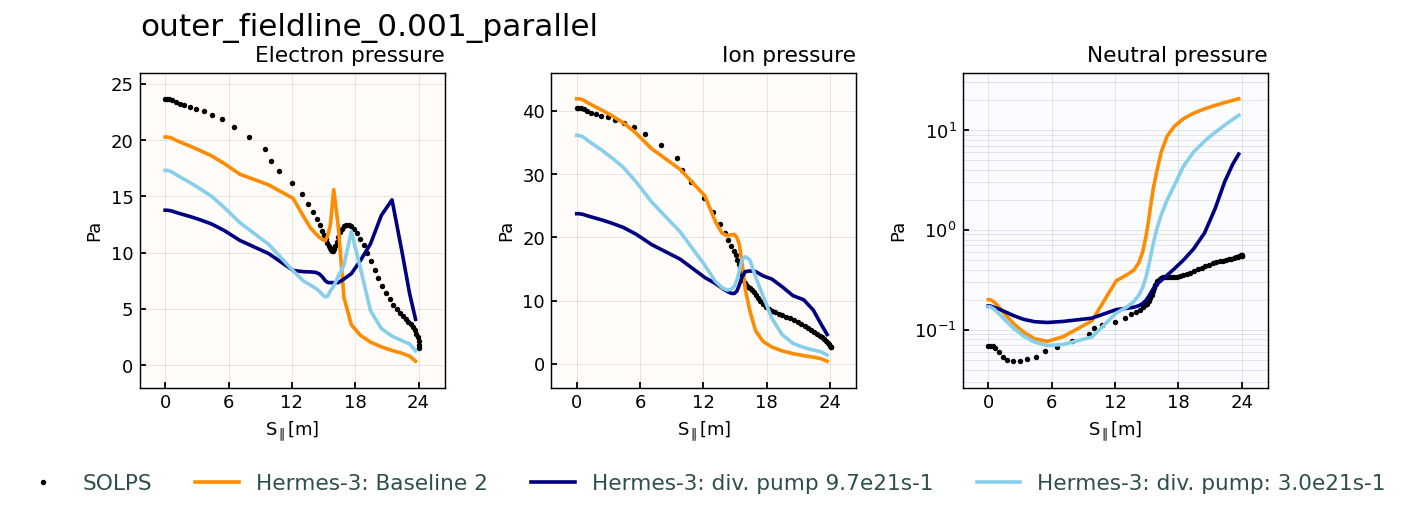

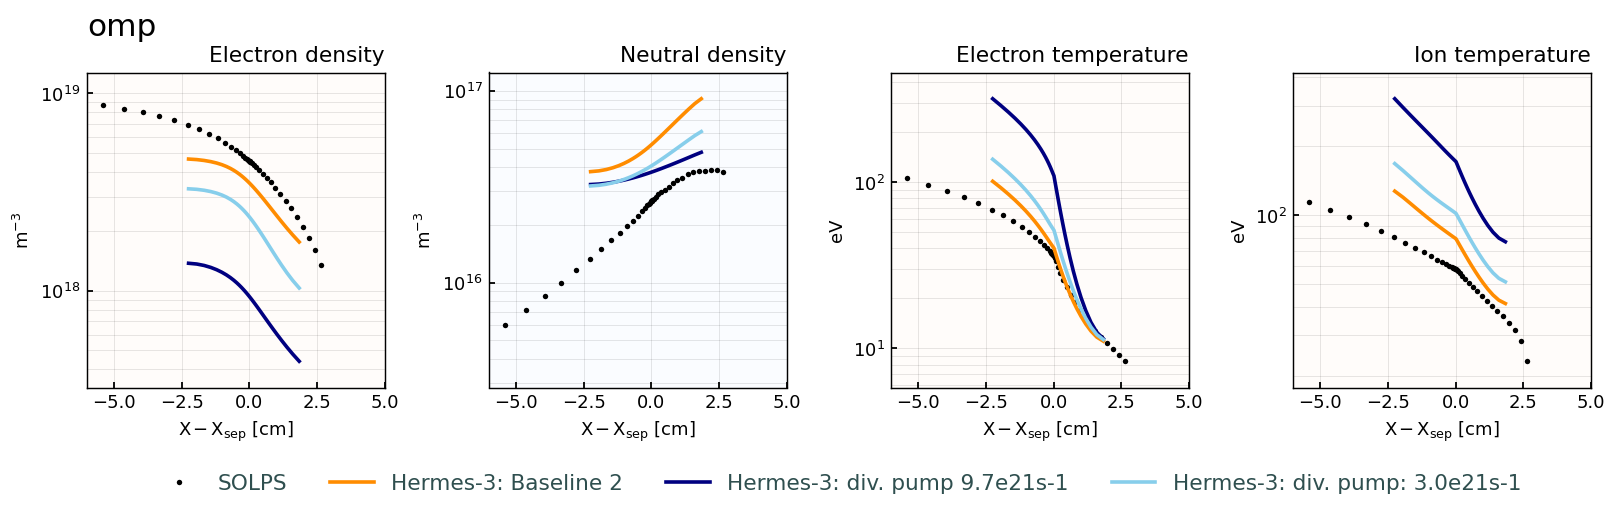

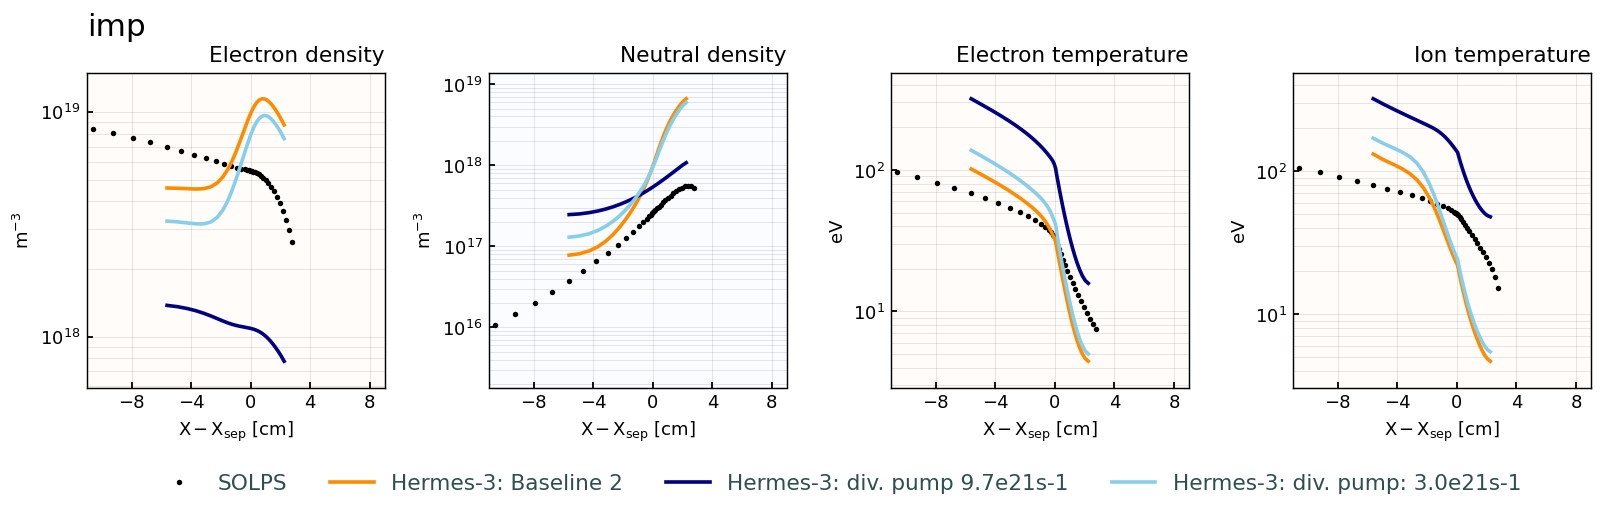

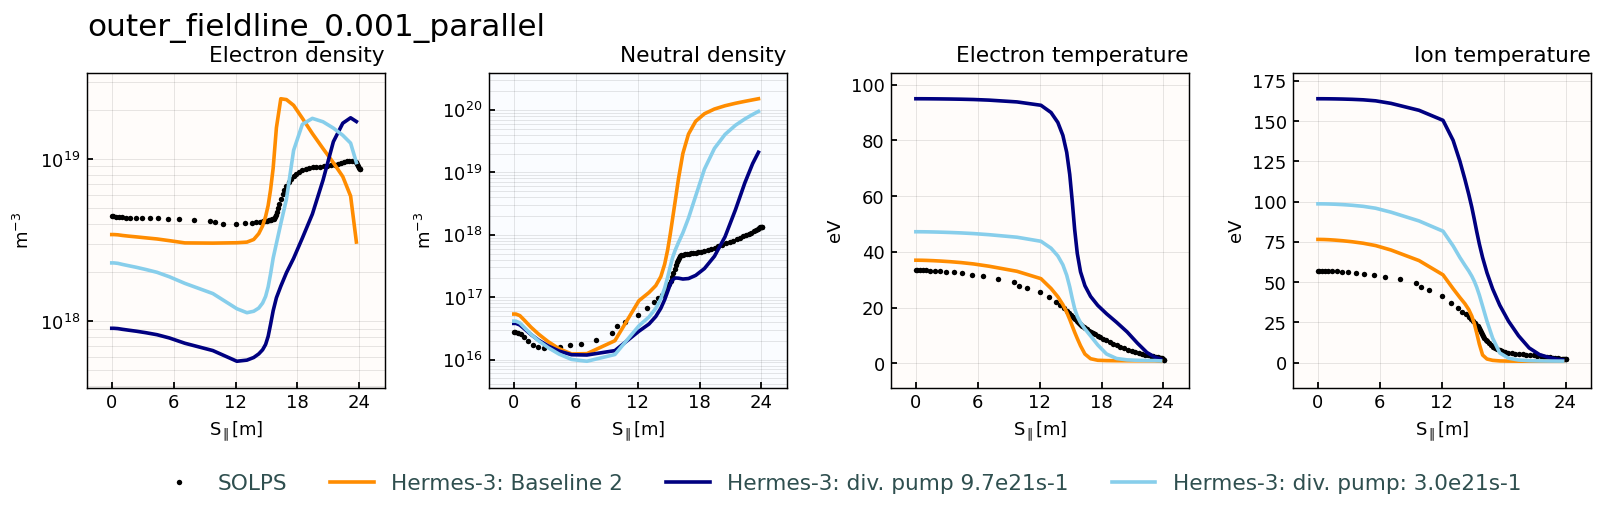

In [6]:
%matplotlib inline
plt.close("all")

params1 = ["Pe", "Pd+", "Pa"]
params2= ["Ne", "Na", "Te", "Td+"]
# params2= ["Ne", "Te"]

for params in [params1, params2]:

    lineplot_compare(
        cases = { 
        "SOLPS" : dict(data=sp["base"], color="black"),
        # r"Hermes-3: Baseline 1 (basis for 1D)" : dict(data=hr['fit_albedo'], color = "teal"),
        # r"Hermes-3: Fcx=off" : dict(data=hr['fit_albedo_noFcx'], color = "darkorange"),
        r"Hermes-3: Baseline 2" : dict(data=hr['Baseline 2'], color = "darkorange"),
        r"Hermes-3: div. pump 9.7e21s-1" : dict(data=hr['Divertor pump: 9.7e21s-1'], color = "navy"),
        r"Hermes-3: div. pump: 3.0e21s-1" : dict(data=hr['Divertor pump: 3.0e21s-1'], color = "skyblue"),
         
        # r"Hermes-3: Tune puff" : dict(data=hr['fit_puff'], color = "darkorange"),
        },
        regions = ["omp", "imp", "outer_fieldline_0.001_parallel"],  
        # regions = ["outer_fieldline_0.001_parallel"],
        # regions = ["outer_lower"],
        params = params,
        mode = "log",
        dpi = 100,
        lw = 2,
        legend_nrows =1,
        combine_molecules = False
    )

# SOLPS comparison - towards baseline 1

In [5]:
hr.keys()

dict_keys(['fit_albedo', 'fit_albedo_noFcx', 'fit_puff', 'reduce_Rc', 'tune_neutalb'])

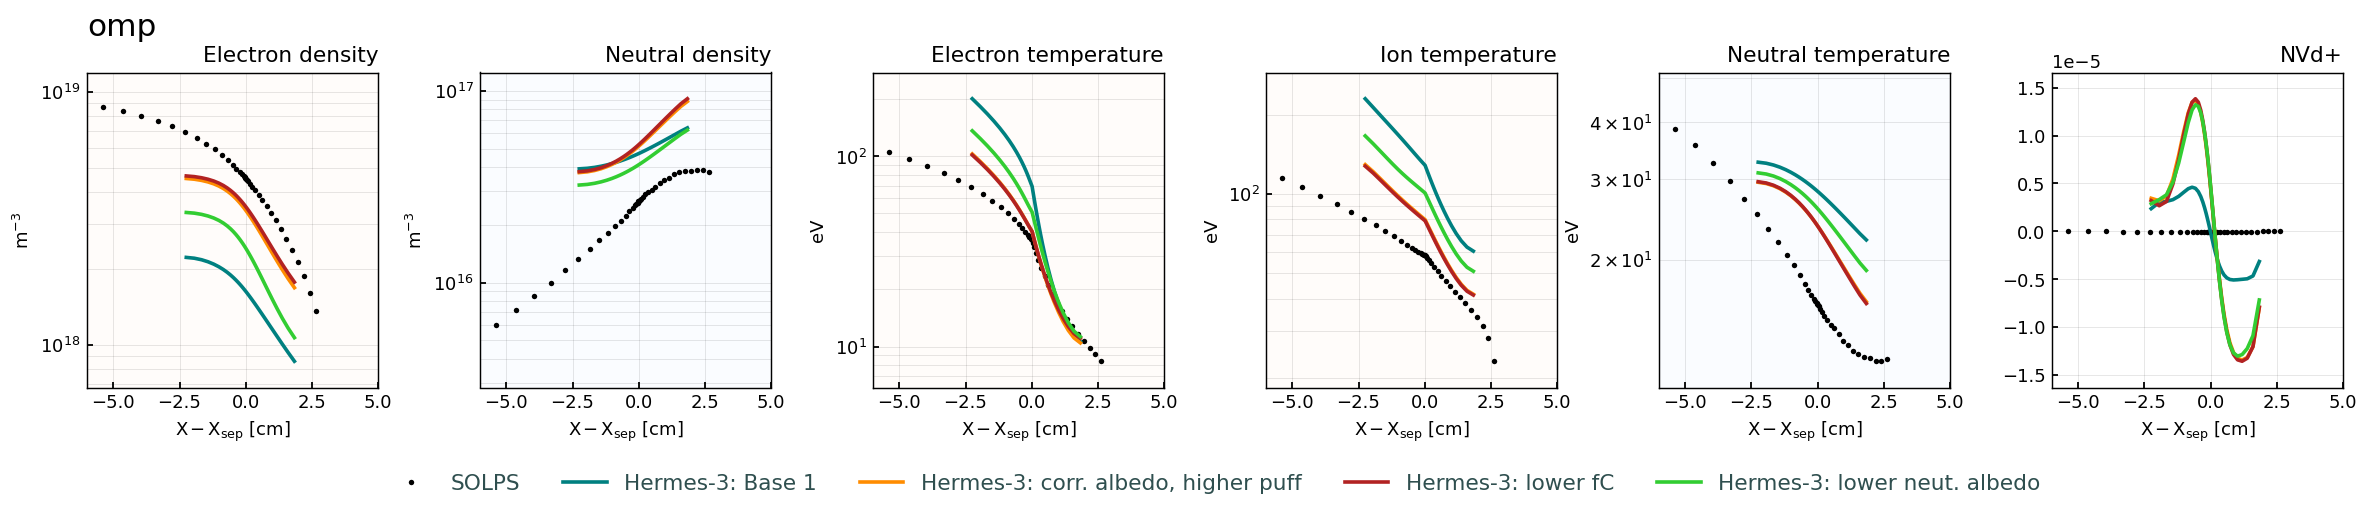

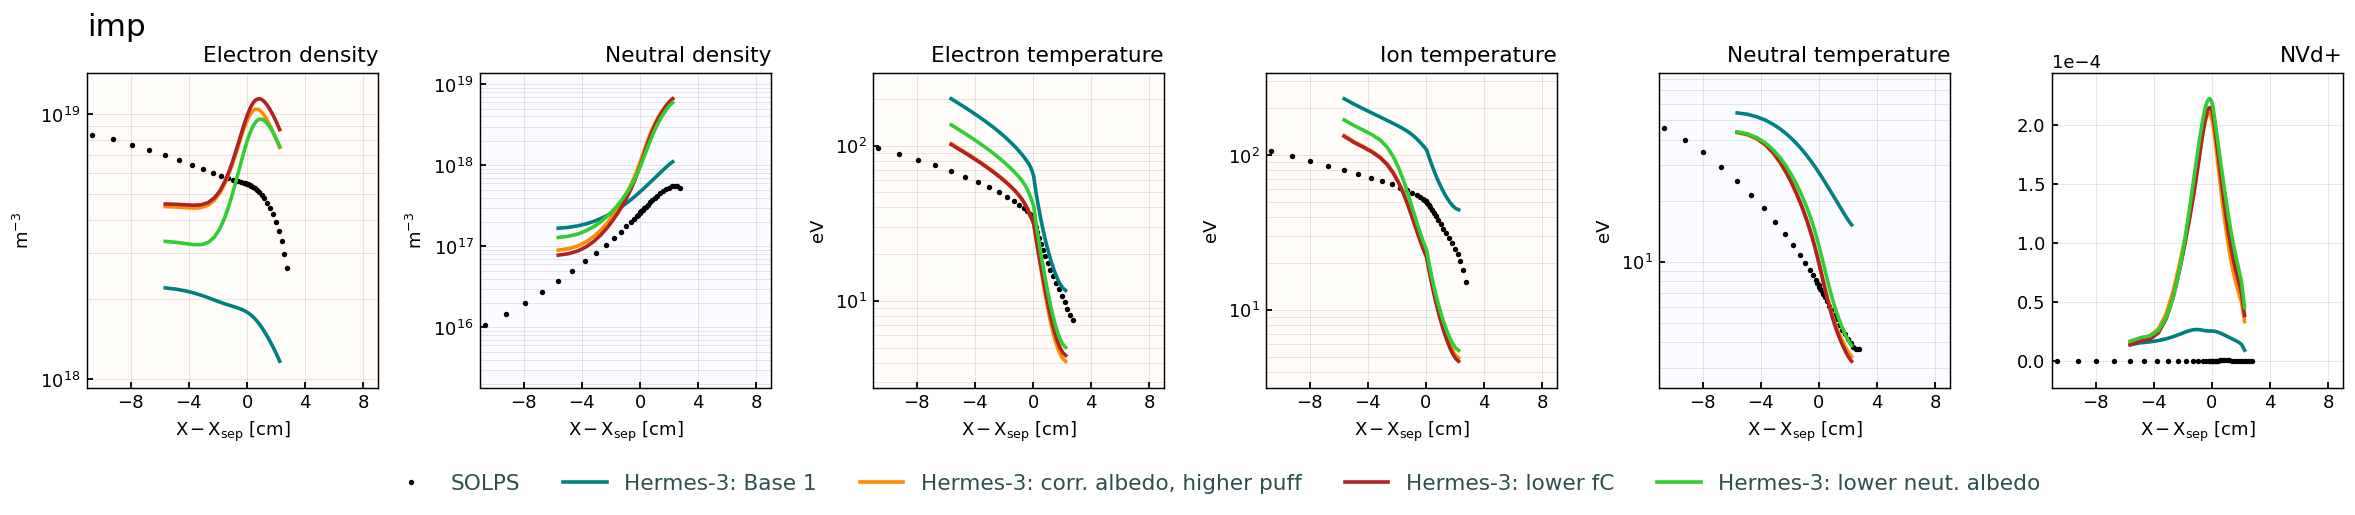

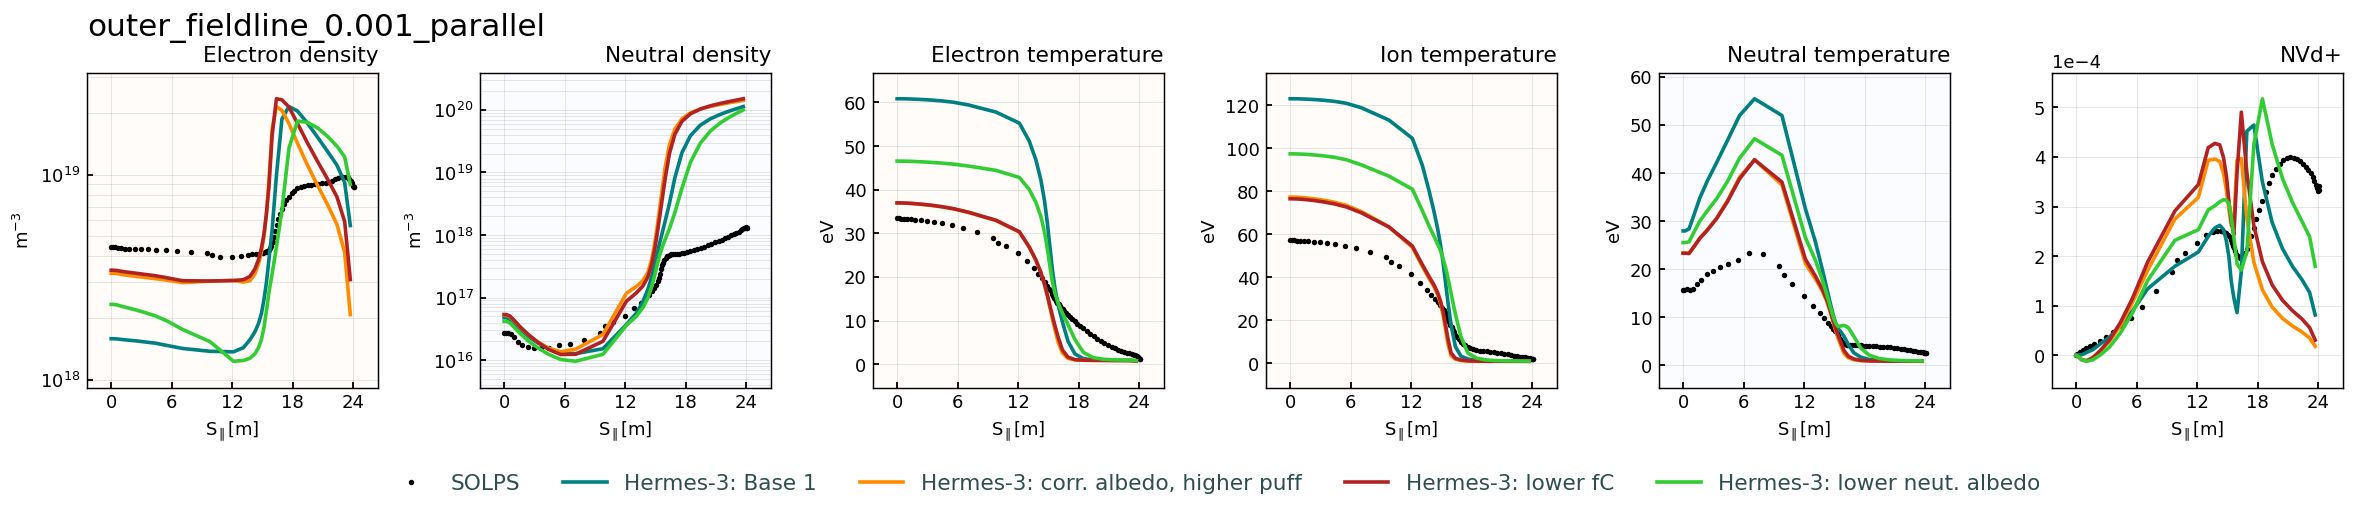

In [9]:
%matplotlib inline
plt.close("all")

lineplot_compare(
    cases = { 
    "SOLPS" : dict(data=sp["base"], color="black"),
    r"Hermes-3: Base 1" : dict(data=hr['fit_albedo'], color = "teal"),
    r"Hermes-3: corr. albedo, higher puff" : dict(data=hr['fit_puff'], color = "darkorange"),
    r"Hermes-3: lower fC" : dict(data=hr['reduce_Rc'], color = "firebrick"),
    r"Hermes-3: lower neut. albedo" : dict(data=hr['tune_neutalb'], color = "limegreen"),
    },
    regions = ["omp", "imp", "outer_fieldline_0.001_parallel"],  
    # regions = ["outer_fieldline_0.001_parallel"],
    # regions = ["outer_lower"],
    # params = ["Pe", "Pd+", "Pa"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta", "Pe", "Pd+", "Pa"],
    params = ["Ne", "Na", "Te", "Td+", "Ta", "NVd+"],
    mode = "log",
    dpi = 100,
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)

## Front tracking

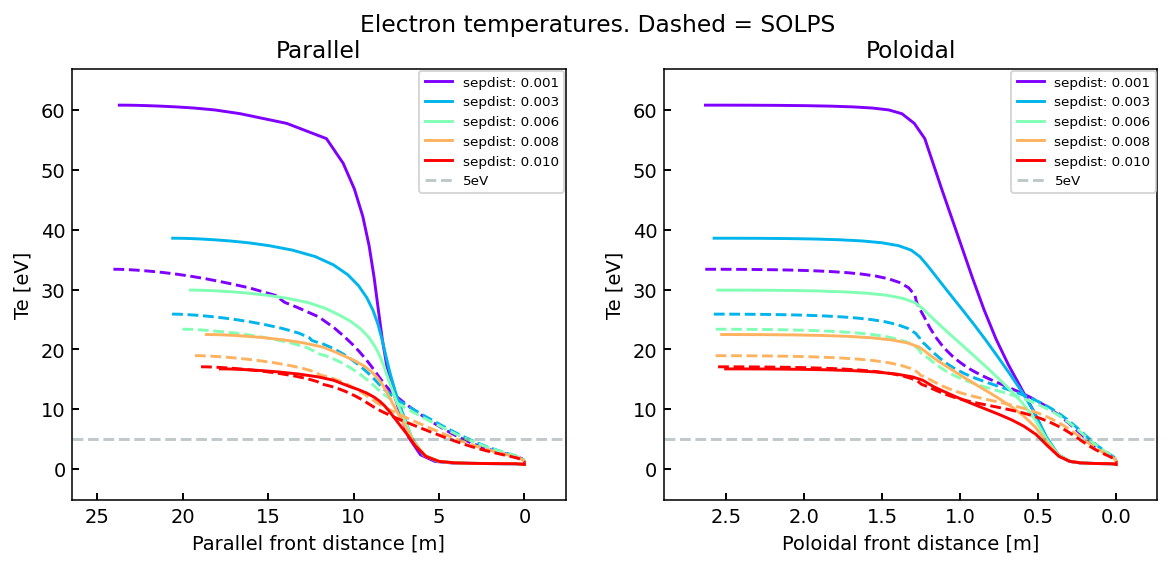

In [86]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
fig.suptitle("Electron temperatures. Dashed = SOLPS")

sepdists = np.linspace(0.001, 0.01, 5)

colors = [plt.cm.rainbow(i) for i in np.linspace(0, 1, len(sepdists))]


ds = cs["fit_albedo"].ds.isel(t=-1)

for i, sepdist in enumerate(sepdists):
    flh = get_1d_poloidal_data(ds, ["Te"], region = "outer_lower", sepdist = sepdist)
    
    
    
    fls = store_slc["base"].get_1d_poloidal_data(params = ["Te"], region = "outer_lower", sepdist = sepdist)
    
    ax = axes[0]
    ax.set_title("Parallel")
    ax.plot((flh["Spar"] - flh["Spar"].iloc[-1])*-1, flh["Te"], label = f"sepdist: {sepdist:.3f}", color = colors[i])
    ax.plot((fls["Spar"] - fls["Spar"].iloc[-1])*-1, fls["Te"], lw = 1.5, ls = "--", color = colors[i])  
    ax.set_xlabel("Parallel front distance [m]")
    ax.invert_xaxis()
    
    ax = axes[1]
    ax.set_title("Poloidal")
    ax.plot((flh["Spol"] - flh["Spol"].iloc[-1])*-1, flh["Te"], label = f"sepdist: {sepdist:.3f}", color = colors[i])
    ax.plot((fls["Spol"] - fls["Spol"].iloc[-1])*-1, fls["Te"], lw = 1.5, ls = "--", color = colors[i])  
    ax.set_xlabel("Poloidal front distance [m]")
    ax.invert_xaxis()

for ax in axes:
    ax.set_xlim()
    xlim = ax.get_xlim()
    ax.hlines(5, *xlim, colors = "darkslategrey", label = "5eV", alpha = 0.3, ls = "--")
    ax.set_xlim(xlim)
    ax.legend(fontsize = "x-small")
    ax.set_ylabel("Te [eV]")

In [50]:
from hermes3.front_tracking import _find_crossing_vectorized

ds = cs["fit_albedo"].ds

sepadd = 0

fl = ds.hermesm.select_custom_sol_ring("outer_lower", sepadd = sepadd).squeeze()
dist = np.cumsum(fl["dl"]).values
pardist = np.cumsum(fl["dr"] * fl["Bpxy"] / fl["Bxy"])
dist_from_target = dist[-1] - dist
pardist_from_target = pardist[-1] - pardist

parfront = _find_crossing_vectorized(pardist, fl["Te"].values, 5)

parfront

array([0.00392136, 0.00391712, 0.00391315, 0.00390947, 0.00390584,
       0.00390216, 0.00389845, 0.00389678, 0.003895  , 0.00389309,
       0.00389114, 0.0038892 , 0.00388723, 0.00388525, 0.00388327,
       0.00388358, 0.00388378, 0.00388382, 0.00388381, 0.0038838 ,
       0.00388379, 0.00388379, 0.00388378])

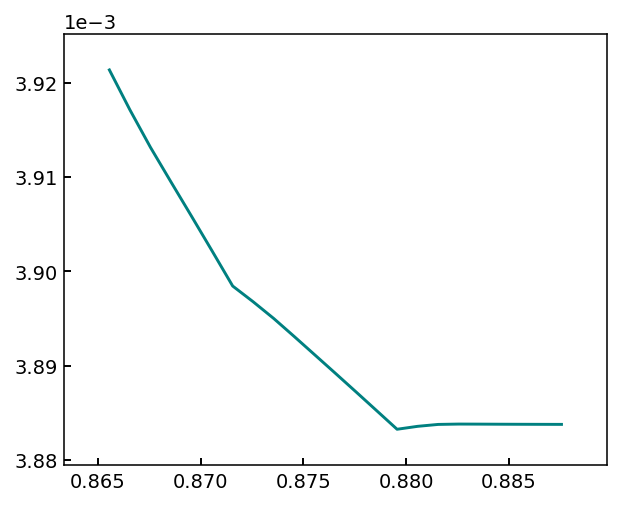

In [51]:
fig, ax = plt.subplots()
ax.plot(ds["t"], parfront)

In [ ]:
for name in cs:
# for name in ["addc_4x"]:
    cs[name].ds.hermesm.get_front_position(more_fronts = False)


76 106


c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\front_tracking.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  df.index = range(ds.dims["t"])
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\front_tracking.py:48: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims["t"]):


Text(0.5, 0, 't [ms]')

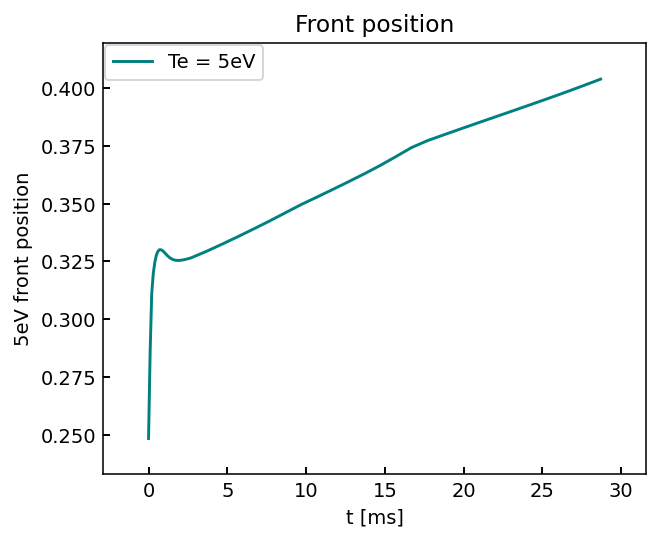

In [ ]:
# ds = cs["tune_4x"].ds

fig, ax = plt.subplots()
ax.plot((ds["t"] - ds["t"][0])*1000, ds["front_poldist_5eV"], label = "Te = 5eV")
# ds["front_poldist_5eV"].plot(ax = ax, label = "Te = 5eV")
# ds["front_poldist_Rpeak"].plot(ax = ax, label = "Radiation peak")
# ds["front_poldist_Nepeak"].plot(ax = ax, label = "Ne peak")
# ds["front_poldist_RECpeak"].plot(ax = ax, label = "Recombination peak")
ax.legend()
ax.set_ylabel("5eV front position")
ax.set_title("Front position")
ax.set_xlabel("t [ms]")

# Neutral pump flux

# Case analysis

In [7]:
cs.keys()

dict_keys(['Baseline 2', 'Divertor pump: 9.7e21s-1', 'Divertor pump: 3.0e21s-1'])

(-2.1, -0.75)

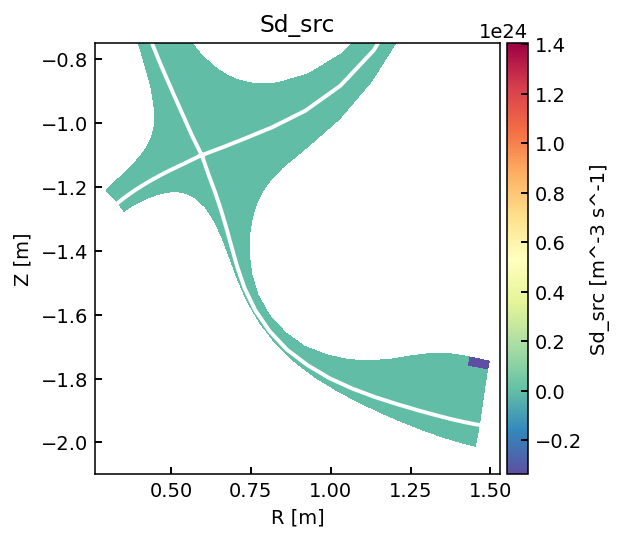

In [13]:
ds = cs['Divertor pump: 9.7e21s-1'].ds.isel(t=-1)

fig, ax = plt.subplots()

ds["Sd_src"].hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", logscale = False)
ax.set_ylim(-2.1, -0.75)

(-2.2, -0.5)

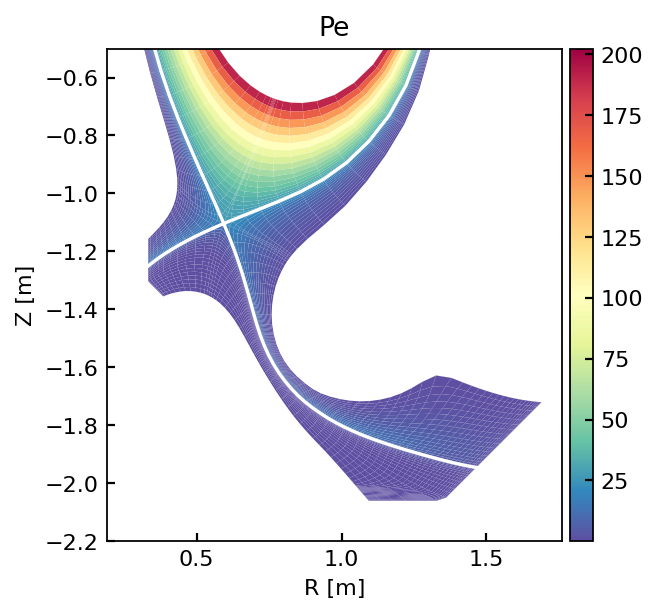

In [ ]:
fig, ax = plt.subplots(dpi = 160)

slc = store_slc["base"]
slc.plot_2d("Pe", ax = ax, vlim = )

ax.set_ylim(-2.2, -0.5)

(-0.2, 0.2)

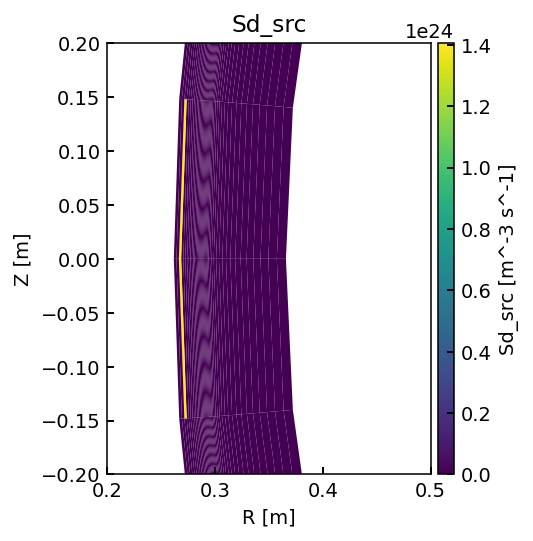

In [190]:
fig, ax =plt.subplots()
cs["next-base"].ds["Sd_src"].bout.polygon(ax = ax, antialias = True, separatrix = False)
ax.set_xlim(0.2, 0.5)
ax.set_ylim(-0.2, 0.2)

In [ ]:


# db = CaseDB(
#     case_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\cases",
#     grid_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid"
# )


In [199]:
name = "m7a-base_from_m6c"
db.casepaths[name]

WindowsPath('C:/Users/Mike/OneDrive/Project/collab/tech/cases/mastu2d/m7a-base_from_m6c')

In [207]:
dsraw = xbout.open_boutdataset(
        datapath=os.path.join(db.casepaths[name], "BOUT.dmp.*.nc"),
        inputfilepath=os.path.join(db.casepaths[name], "BOUT.inp"),
        # chunks=chunks,
        # run_name=run_name,
        info=False,
        # **kwargs,
    )

In [211]:
dsraw["y"].isel(t=-1).bout.pcolormesh()

ValueError: Dimensions {'t'} do not exist. Expected one or more of ('y',)

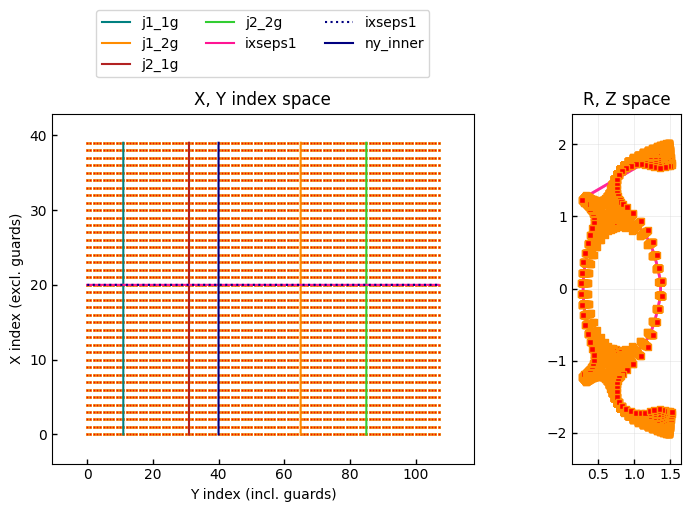

In [196]:
sel = ds.where(ds["poloidal_distance"] > 3)

plot_selection(ds, sel)



# EIRENE diags

## Read Fort46

In [157]:
path = r"C:\Users\Mike\OneDrive\Project\lot2_2d\Moulton MAST-U SOLPS runs\45456-Dec1523-seq-23\puff=1.5e21_pump=0.001_nodrifts_bcmom2_parmvsa2_redoutpfrtrans"
fort46 = read_ft46(where = path, save = False)

read_ft46: -- file version 20170930


## Get neutral pressures

In [151]:
# Norm from g cm^-2 s^-1 to kg m^-2 s^-1:

Gax = fort46["vxdena"][:,0]     # already [kg m^-2 s^-1] thanks to Matteo routine
Gay = fort46["vydena"][:,0]     # already [kg m^-2 s^-1] thanks to Matteo routine
Gaz = fort46["vzdena"][:,0]     # already [kg m^-2 s^-1] thanks to Matteo routine
Na = fort46["pdena"][:,0]    # Already in m^-3 thanks to Matteo routine
Ma = constants("mass_p")*2
Pastat = fort46["edena"][:,0]    # Already in Pa thanks to Matteo routine

Gmx = fort46["vxdenm"][:,0]  # [kg m^-2 s^-1]
Gmy = fort46["vydenm"][:,0]  # [kg m^-2 s^-1]
Gmz = fort46["vzdenm"][:,0]  # [kg m^-2 s^-1]
Nm = fort46["pdenm"][:,0]    # Already in m^-3 thanks to Matteo routine
Mm = constants("mass_p")*2*2
Pmstat = fort46["edenm"][:,0]    # Already in Pa thanks to Matteo routine

# To get velocity:
# G = kg m^-2 s^-1
# G / Ma = m^-2 s^-1
# G / Ma / Na = m^-2 s^-1 * m^3 = Vn = ms^-1

Vax = Gax / Na / Ma
Vay = Gay / Na / Ma
Vaz = Gaz / Na / Ma

Padynx = 0.5 * Ma * Na * Vax**2
Padyny = 0.5 * Ma * Na * Vay**2
Padynz = 0.5 * Ma * Na * Vaz**2

Patot = Padynx + Padyny + Padynz + Pastat

Vmx = Gmx / Nm / Mm
Vmy = Gmy / Nm / Mm
Vmz = Gmz / Nm / Mm

Pmdynx = 0.5 * Mm * Nm * Vmx**2
Pmdyny = 0.5 * Mm * Nm * Vmy**2
Pmdynz = 0.5 * Mm * Nm * Vmz**2

Pmtot = Pmdynx + Pmdyny + Pmdynz + Pmstat

fort46["Padynx"] = Padynx
fort46["Padyny"] = Padyny
fort46["Padynz"] = Padynz
fort46["Pastat"] = Pastat
fort46["Patot"] = Patot

fort46["Pmdynx"] = Pmdynx
fort46["Pmdyny"] = Pmdyny
fort46["Pmdynz"] = Pmdynz
fort46["Pmstat"] = Pmstat
fort46["Pmtot"] = Pmtot
fort46["Na"] = Na


## 2D plot of atom velocities

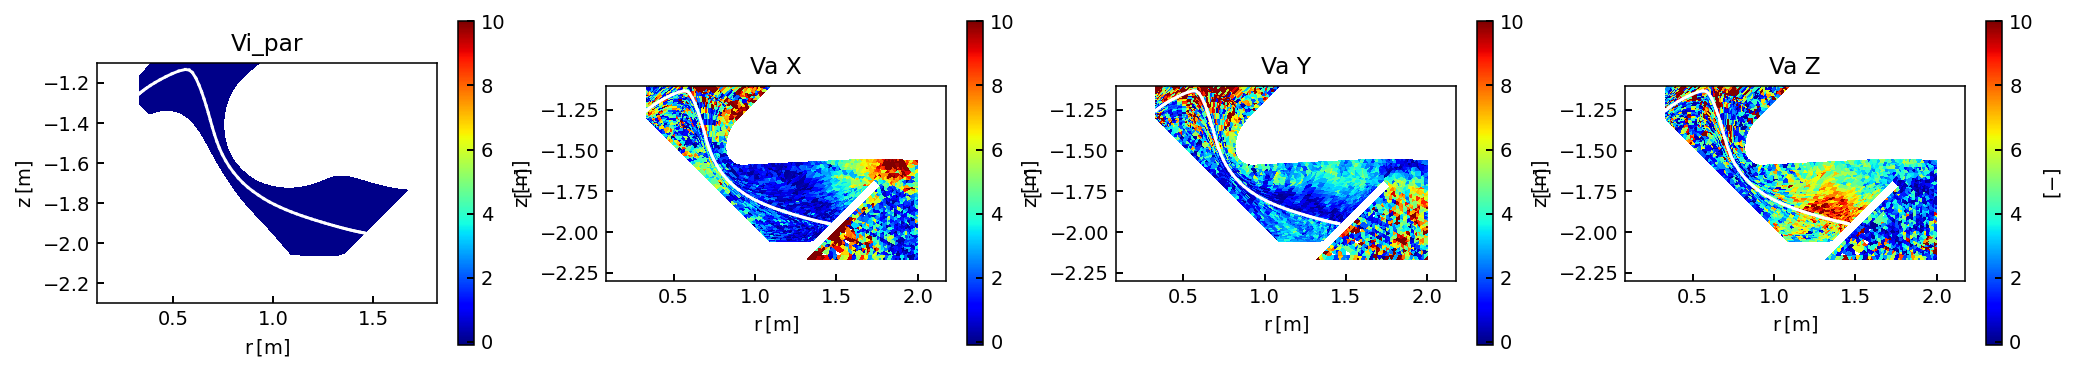

In [50]:
vmax = 0
vmin = 10
fig, axes = plt.subplots(1,4,figsize=(18,3))
scale = "linear"
cmap = "jet"
with HiddenPrints():
        
        ax = axes[0]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D+"], what = ["ua"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = None)
        ax.set_title("Vi_par")
        
        ax = axes[1]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = abs(Vax)*1e-3)
        ax.set_title("Va X")

        ax = axes[2]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = abs(Vay)*1e-3)
        ax.set_title("Va Y")

        ax = axes[3]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = abs(Vaz)*1e-3)
        ax.set_title("Va Z")

for ax in axes:
        ax.set_ylim(-2.3, -1.1)


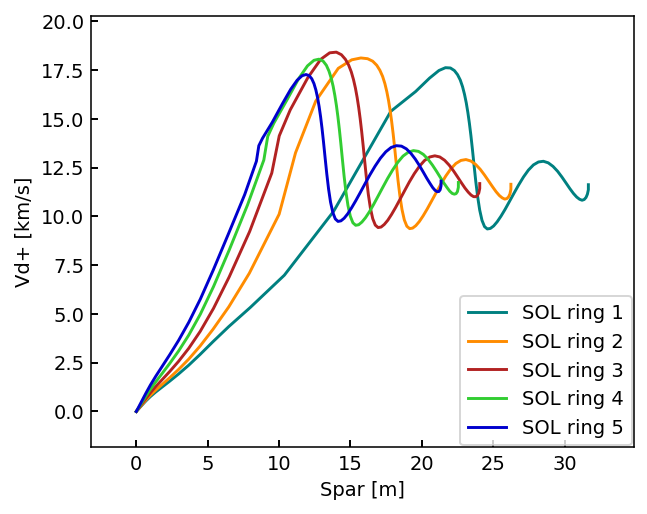

In [41]:
fig, ax = plt.subplots()

for sepadd in range(5):
    df = slc.get_1d_poloidal_data(["Vd+"], sepadd = sepadd)

    
    ax.plot(df["Spar"], df["Vd+"]/1000, label = f"SOL ring {sepadd+1}")
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Vd+ [km/s]")
ax.legend()

# df

In [18]:
v = 1e5
R  = 1.2
omega = v / R
RPM = 30 * v / (np.pi * R)
print(f"The neutrals are spinning at {RPM:.0f} RPM")

The neutrals are spinning at 795775 RPM


## 2D plot of densities

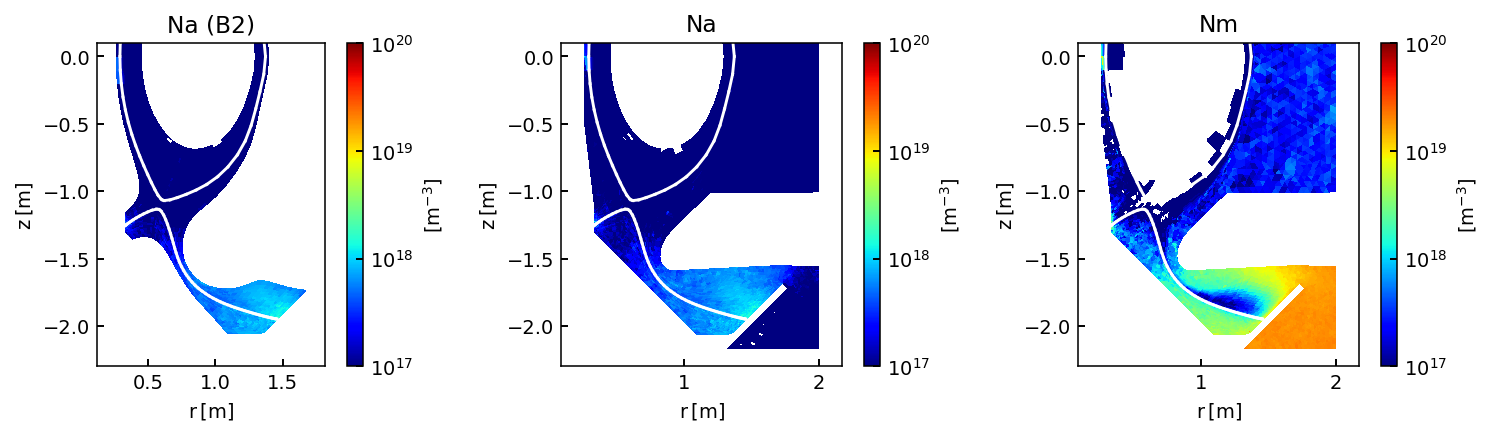

In [ ]:
vmax = 1e20
vmin = 1e17
fig, axes = plt.subplots(1,3,figsize=(9+4.5,3))
scale = "log"
cmap = "jet"
with HiddenPrints():
        
        ax = axes[0]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["dab2"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = None)
        ax.set_title("Na (B2)")
        
        ax = axes[1]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["pdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = fort46["pdena"][:,0])
        ax.set_title("Na")
        
        ax = axes[2]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["pdenm"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = None)
        ax.set_title("Nm")

        

        # ax = axes[3]
        # plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
        #         vmin = vmin, vmax = vmax, value_override = Padynz)
        # ax.set_title("Pdyn Z")

for ax in axes:
        ax.set_ylim(-2.3, 0.1)


## 2D plot of atom pressures

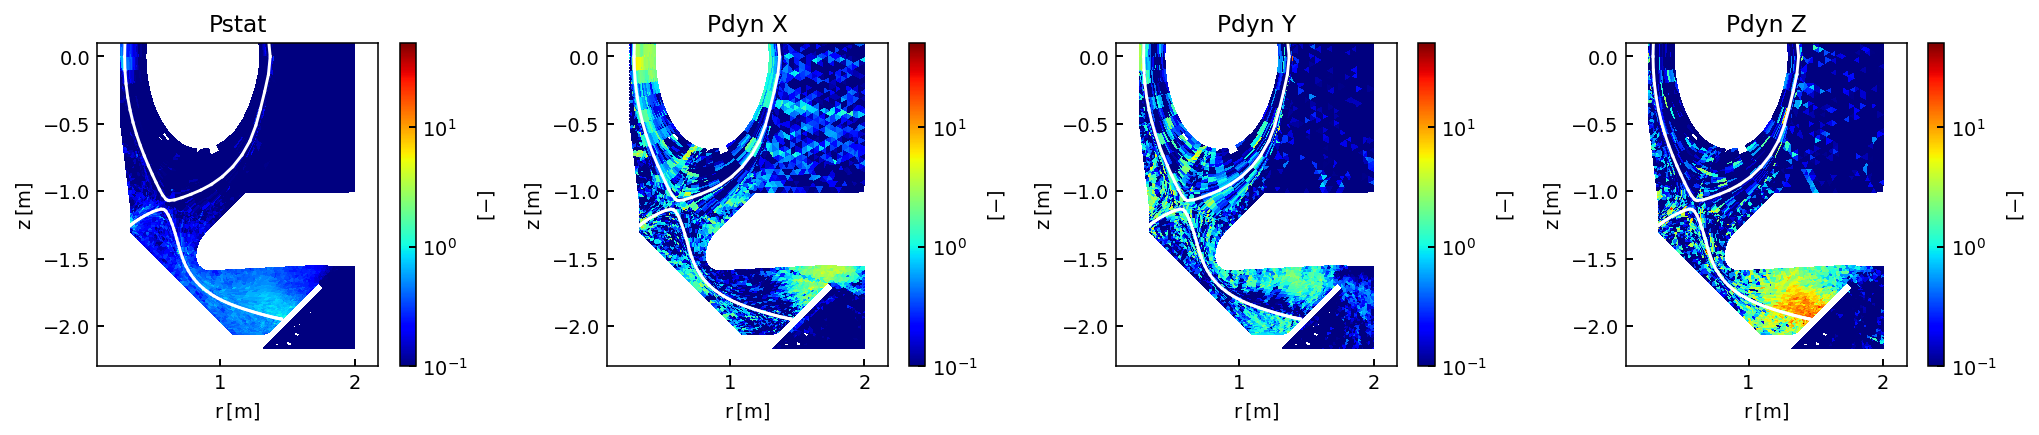

In [199]:
vmax = 50
vmin = 0.1
fig, axes = plt.subplots(1,4,figsize=(18,3))
scale = "log"
cmap = "jet"
with HiddenPrints():
        
        ax = axes[0]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Pastat)
        ax.set_title("Pstat")
        
        ax = axes[1]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Padynx)
        ax.set_title("Pdyn X")

        ax = axes[2]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Padyny)
        ax.set_title("Pdyn Y")

        ax = axes[3]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Padynz)
        ax.set_title("Pdyn Z")

for ax in axes:
        ax.set_ylim(-2.3, 0.1)


## 2D plot of molecule pressures

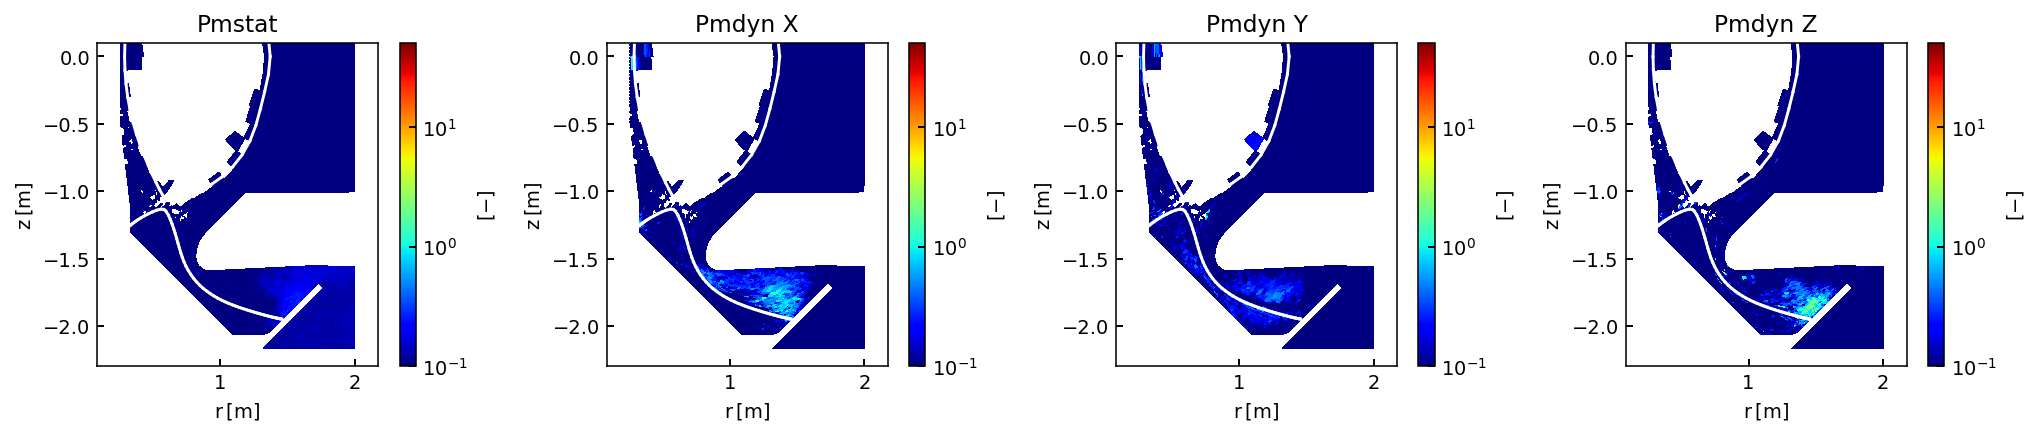

In [200]:
vmax = 50
vmin = 0.1
fig, axes = plt.subplots(1,4,figsize=(18,3))
scale = "log"
cmap = "jet"
with HiddenPrints():
        
        ax = axes[0]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Pmstat)
        ax.set_title("Pmstat")
        
        ax = axes[1]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Pmdynx)
        ax.set_title("Pmdyn X")

        ax = axes[2]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Pmdyny)
        ax.set_title("Pmdyn Y")

        ax = axes[3]
        plot_2d(fig = fig, ax = ax, scale = scale, where = [path], species = ["D"], what = ["vxdena"], cmap = cmap,
                vmin = vmin, vmax = vmax, value_override = Pmdynz)
        ax.set_title("Pmdyn Z")

for ax in axes:
        ax.set_ylim(-2.3, 0.1)


## Line interpolation

In [152]:
def intep_tri_on_line(triangulation, data, X, Y):

    # Assume you have your triangulation and cell-centered values
    triang = triangulation  # Your existing triangulation object
    cell_values = data  # Assuming this has a value per triangle

    # Get number of nodes
    num_nodes = len(triang.x)

    # Initialize arrays for summing contributions and counting occurrences
    node_values = np.zeros(num_nodes)
    node_counts = np.zeros(num_nodes)

    # Loop through each triangle and distribute its value to its three nodes
    for tri_index, nodes in enumerate(triang.triangles):
        for node in nodes:
            node_values[node] += cell_values[tri_index]  # Add triangle value to node
            node_counts[node] += 1  # Count contributions to the node

    # Avoid division by zero (shouldn't happen in a well-formed triangulation)
    node_counts[node_counts == 0] = 1

    # Compute the final averaged node values
    node_values /= node_counts

    # Now node_values is node-centered and can be used for interpolation

    analyzer = tri.TriAnalyzer(triang)
    triangle_areas = analyzer.circle_ratios()  # Proxy for area weighting

    weighted_node_values = np.zeros(num_nodes)
    weighted_counts = np.zeros(num_nodes)

    for tri_index, nodes in enumerate(triang.triangles):
        area = triangle_areas[tri_index]
        for node in nodes:
            weighted_node_values[node] += cell_values[tri_index] * area
            weighted_counts[node] += area

    weighted_counts[weighted_counts == 0] = 1
    weighted_node_values /= weighted_counts  # Weighted average

    interp = tri.LinearTriInterpolator(triang, weighted_node_values)     # Noisy
    # interp = tri.CubicTriInterpolator(triang, weighted_node_values)      # Overfits, leads to "waves" in Nn
    # interp = scipy.interpolate.CloughTocher2DInterpolator(list(zip(triang.x, triang.y)), node_values)  # Also makes noise
    
    return interp(X,Y)
    


### Get tri data interpolated on line

Padynx
Padyny
Padynz
Pastat
Pmdynx
Pmdyny
Pmdynz
Pmstat


Text(0.5, 1.0, 'Interpolation check: Na')

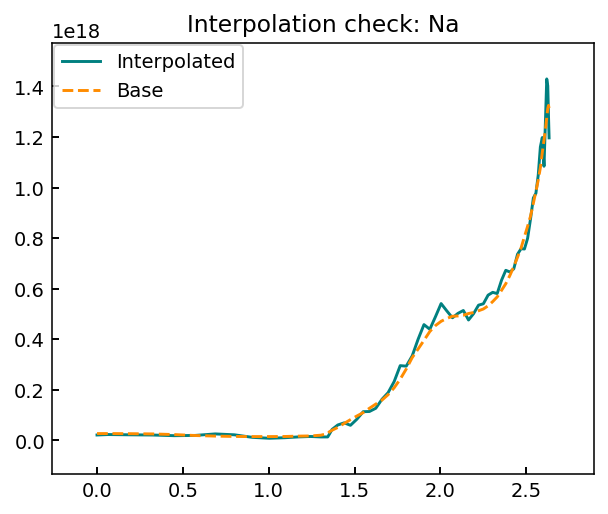

In [153]:
from gridtools.solps_python_scripts.read_triangle_mesh import read_triangle_mesh
from gridtools.solps_python_scripts.utilities.accessories import rearrange_quadrangles, rearrange_triangles

from scipy.interpolate import Rbf
import matplotlib.tri as tri

triangles = read_triangle_mesh(where = path, verbose = False, save = False)
cells = triangles['cells']  # Node indices of each triangle
nodes = triangles['nodes']  # X, Y coords of triangulated grid
triangulation = tri.Triangulation(nodes[:,0], nodes[:,1], cells)
cells = rearrange_triangles(cells = cells)


slc = store_slc["base"]
fl = slc.get_1d_poloidal_data(["Na", "Nn", "Nm", "Ta", "Tn", "Tm", "Pa", "Pn", "Pm", "Pe", "Pd+", "Vd+", "Ne"], sepdist = 0.001)
fl["Pidyn"] = 0.5 * constants("mass_p")*2 * fl["Ne"] * fl["Vd+"]**2
fl["Pistat"] = fl["Pd+"]

for param in ["Padynx", "Padyny", "Padynz", "Pastat", "Pmdynx", "Pmdyny", "Pmdynz", "Pmstat"]:
    print(param)
    fl[param] = intep_tri_on_line(triangulation = triangulation, data = fort46[param], X = fl["R"].values, Y = fl["Z"].values)
    
# For check
fl["Na_interp"] = intep_tri_on_line(triangulation = triangulation, data = fort46["Na"], X = fl["R"].values, Y = fl["Z"].values)

fig, ax = plt.subplots()
ax.plot(fl["Spol"], fl["Na_interp"], label = "Interpolated")
ax.plot(fl["Spol"], fl["Na"], label = "Base", ls = "--")
ax.legend()
ax.set_title("Interpolation check: Na")

In [ ]:
fl.columns

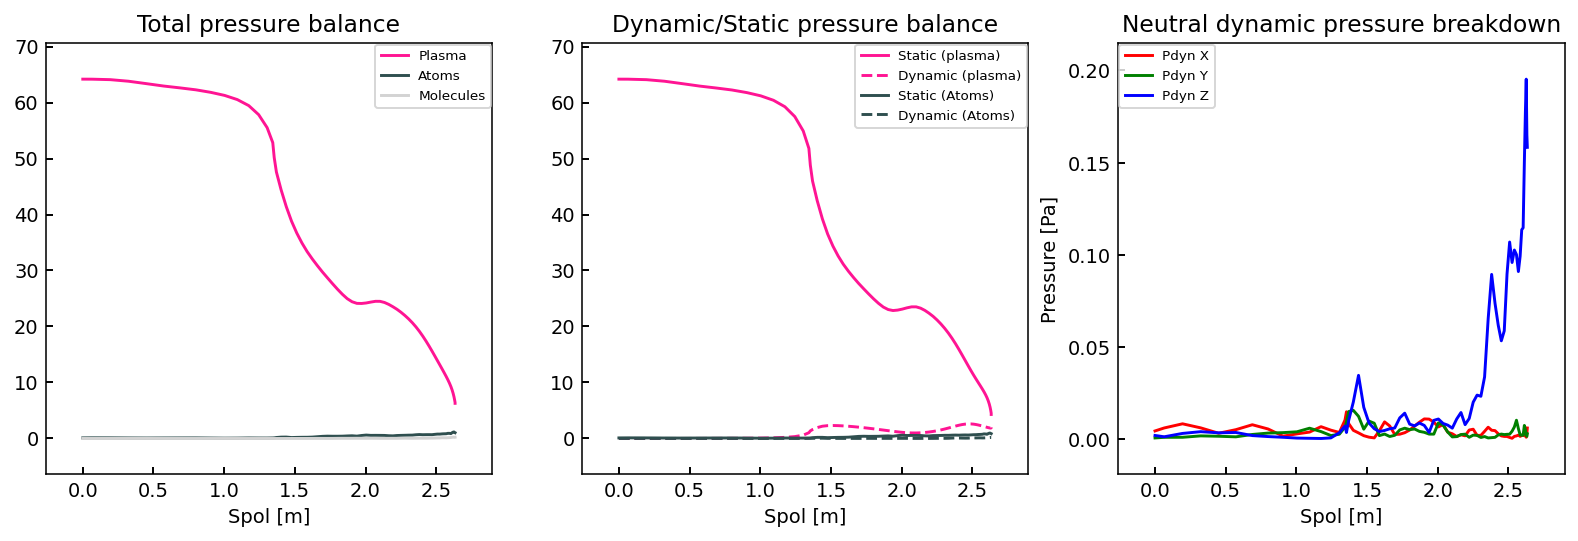

In [176]:
fl["Pestat"] = fl["Pe"]
fl["Padyntot"] = fl["Padynx"] + fl["Padyny"] + fl["Padynz"] 
fl["Patot"] = fl["Padyntot"] + fl["Pastat"]
fl["Pmdyntot"] = fl["Pmdynx"] + fl["Pmdyny"] + fl["Pmdynz"] 
fl["Pmdyntot"] = fl["Pmdyntot"].fillna(0)
fl["Pmtot"] = fl["Pmdyntot"] + fl["Pmstat"]
fl["Pitot"] = fl["Pidyn"] + fl["Pistat"]
fl["Petot"] = fl["Pestat"]
fl["Ptot"] = fl["Patot"] + fl["Pmtot"] + fl["Pitot"] + fl["Petot"]

c_ion = "tomato"
c_electron = "skyblue"
c_atom = "darkslategrey"
c_molecule = "lightgrey"
c_plasma = "deeppink"


fig, axes = plt.subplots(1,3, figsize = (14,4))

ax = axes[0]
ax.set_title("Total pressure balance")
ax.plot(fl["Spol"], fl["Pe"] + fl["Pd+"] + fl["Pidyn"], label = "Plasma", c = c_plasma)
ax.plot(fl["Spol"], fl["Patot"], c = c_atom, label = "Atoms")
ax.plot(fl["Spol"], fl["Pmtot"], c = c_molecule, label = "Molecules")

ax = axes[1]
ax.set_title("Dynamic/Static pressure balance")
ax.plot(fl["Spol"], fl["Pe"] + fl["Pd+"], label = "Static (plasma)", c = c_plasma)
ax.plot(fl["Spol"], fl["Pidyn"], label = "Dynamic (plasma)", c = c_plasma, ls = "--")
ax.plot(fl["Spol"], fl["Pastat"], label = "Static (Atoms)", c = c_atom)
ax.plot(fl["Spol"], fl["Padyntot"], label = "Dynamic (Atoms)", c = c_atom, ls = "--")

ax = axes[2]
ax.set_title("Neutral dynamic pressure breakdown")
ax.plot(fl["Spol"], fl["Padynx"], label = "Pdyn X", c = "r")
ax.plot(fl["Spol"], fl["Padyny"], label = "Pdyn Y", c = "g")
ax.plot(fl["Spol"], fl["Padynz"], label = "Pdyn Z", c = "b")

# ax.plot(fl["Spol"], fl["Pe"], label = "Pstat_e", c = c_electron)
# ax.plot(fl["Spol"], fl["Pd+"], label = "Pstat_i", c = c_ion)
# ax.plot(fl["Spol"], fl["Pd+_dyn"], label = "Pdyn_i", c = c_ion, ls = "--")
# ax.plot(fl["Spol"], fl["Pa"], label = "Pstat_n", c = "darkslategrey")


ax.set_ylabel("Pressure [Pa]")
for ax in axes:
    ax.set_xlabel("Spol [m]")
    ax.legend(fontsize = "x-small")


None 0.001
76 106


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


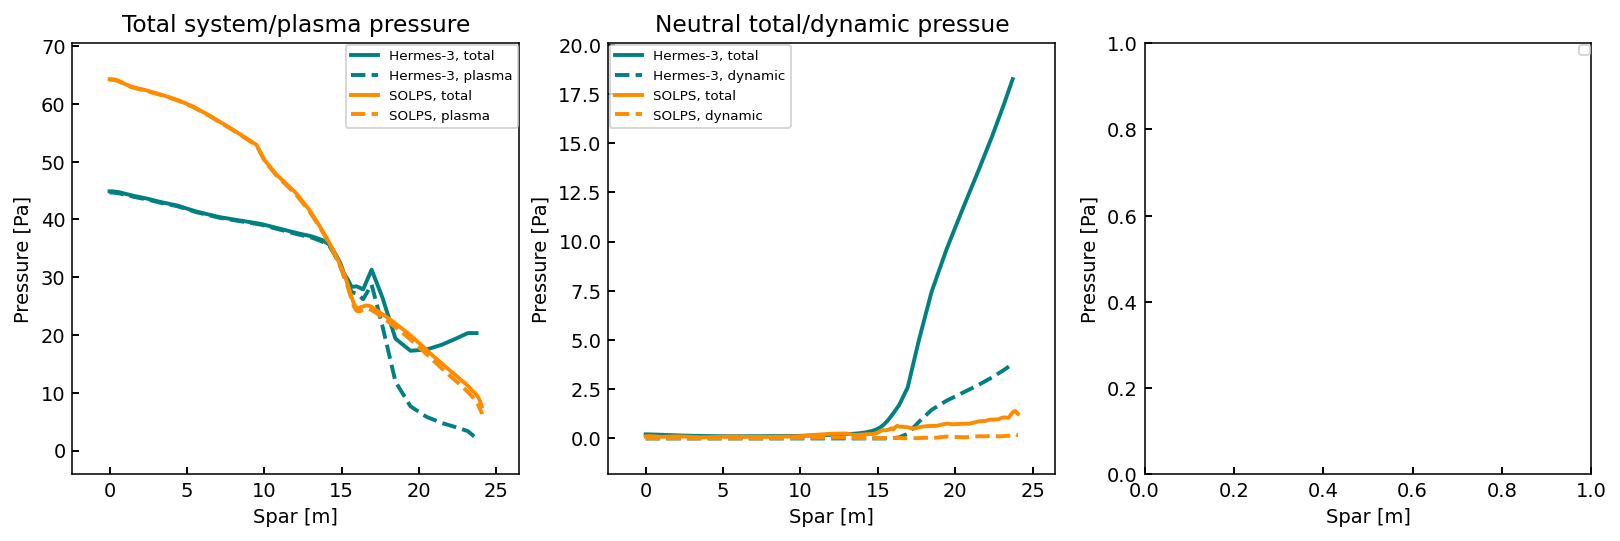

In [181]:

ds = cs["next-base"].ds.isel(t=-1)
flh = get_1d_poloidal_data(ds, params = ["Pe", "Pd+", "Pd", "Vd+", "NVd", "Ne", "Nd"], region = "outer_lower", sepdist = 0.001)
flh["Vd"] = flh["NVd"] / flh["Nd"] / (constants("mass_p")*2)
flh["Pidyn"] = 0.5 * constants("mass_p")*2 * flh["Ne"] * flh["Vd+"]**2
flh["Padyn"] = 0.5 * constants("mass_p")*2 * flh["Nd"] * flh["Vd"]**2

flh["Pastat"] = flh["Pd"]
flh["Pestat"] = flh["Pe"]
flh["Pistat"] = flh["Pd+"]
flh["Pitot"] = flh["Pidyn"] + flh["Pistat"]
flh["Petot"] = flh["Pestat"]
flh["Padyntot"] = flh["Padyn"]
flh["Patot"] = flh["Padyntot"] + flh["Pastat"]

flh["Ptot"] = flh["Patot"] + flh["Pitot"] + flh["Petot"]


c_all = "black"
c_ion = "tomato"
c_electron = "skyblue"
c_atom = "darkslategrey"
c_molecule = "lightgrey"
c_plasma = "deeppink"
s_solps = dict(lw = 2, c = "darkorange")
s_hermes = dict(lw = 2, c = "teal")


fig, axes = plt.subplots(1,3, figsize = (14,4))

ax = axes[0]
ax.set_title("Total system/plasma pressure")
ax.plot(flh["Spar"], flh["Ptot"], label = "Hermes-3, total", **s_hermes)
ax.plot(flh["Spar"], flh["Petot"] + flh["Pitot"], label = "Hermes-3, plasma", ls = "--", **s_hermes)
ax.plot(fl["Spar"], fl["Ptot"], label = "SOLPS, total", **s_solps)
ax.plot(fl["Spar"], fl["Petot"] + fl["Pitot"], label = "SOLPS, plasma", ls = "--", **s_solps)

# ax = axes[1]
# ax.set_title("Total plasma pressure")
# ax.plot(flh["Spar"], flh["Petot"] + flh["Pitot"], label = "Hermes-3", **s_hermes)
# ax.plot(fl["Spar"], fl["Petot"] + fl["Pitot"], label = "SOLPS", **s_solps)

ax = axes[1]
ax.set_title("Neutral total/dynamic pressue")
ax.plot(flh["Spar"], flh["Patot"], label = "Hermes-3, total",  **s_hermes)
ax.plot(flh["Spar"], flh["Padyn"], label = "Hermes-3, dynamic", **s_hermes, ls = "--")
ax.plot(fl["Spar"], fl["Patot"] + fl["Pmtot"], label = "SOLPS, total",  **s_solps)
ax.plot(fl["Spar"], fl["Padyntot"] + fl["Pmdyntot"], label = "SOLPS, dynamic", **s_solps, ls = "--")
# ax.plot(flh["Spar"], flh["Pe"] + flh["Pd+"], label = "Plasma total, Hermes-3", c = c_plasma, **s_hermes)

for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("Spar [m]")
    ax.set_ylabel("Pressure [Pa]")

(0.0, 24.3)

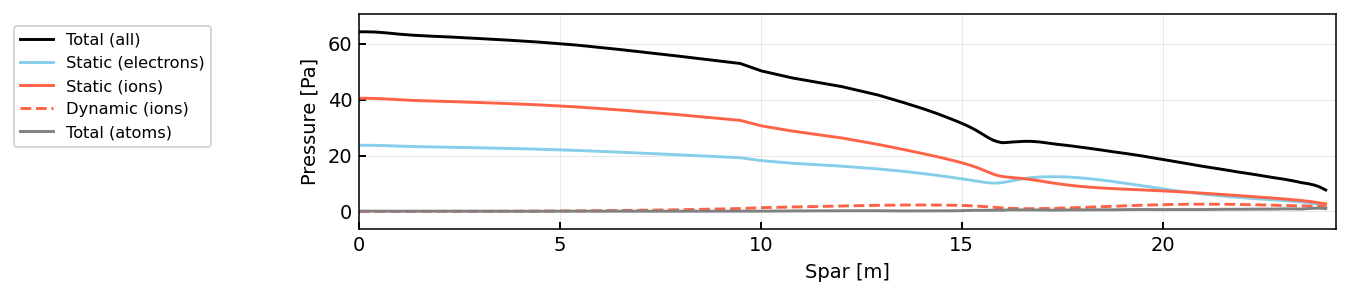

In [244]:
fig, ax = plt.subplots(figsize = (9,2))

x = fl["Spar"] 

ax.plot(x, fl["Ptot"], label = "Total (all)", c= "k")
ax.plot(x, fl["Pestat"], label = "Static (electrons)", c = "skyblue")
ax.plot(x, fl["Pistat"], label = "Static (ions)", c = "tomato")
ax.plot(x, fl["Pidyn"], label = "Dynamic (ions)", c = "tomato", ls = "--")
ax.plot(x, fl["Patot"], label = "Total (atoms)", c = "grey")

ax.legend(loc = "upper right", bbox_to_anchor = (-0.15, 0.95), ncols = 1, fontsize = "small")
ax.grid()
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Pressure [Pa]")
ax.set_xlim(0,24.3)
# ax.set_xlim(48, 65.5)

## Total particle count

In [161]:
fort46 = read_ft46(where = path, save = False)

ds = cs["next-base"].ds.isel(t=-1)
hermes_plasma = (ds["Ne"].hermesm.clean_guards() * ds["dv"]).sum().values
hermes_atoms = (ds["Nd"].hermesm.clean_guards() * ds["dv"]).sum().values

solps_atoms = (fort46["pdena"][:,0] * fort46["volumes"]).sum()
solps_molecules = (fort46["pdenm"][:,0] * fort46["volumes"]).sum()
solps_neutrals = solps_atoms + solps_molecules

df = pd.DataFrame()
df.loc["Total", "Hermes-3"] = hermes_plasma + hermes_atoms
df.loc["Plasma", "Hermes-3"] = hermes_plasma
df.loc["Neutrals", "Hermes-3"] = hermes_atoms
df.loc["Of which atoms:", "Hermes-3"] = hermes_atoms
df.loc["Of which molecules:", "Hermes-3"] = 0


df.loc["Total", "SOLPS"] = solps_plasma + solps_neutrals
df.loc["Plasma", "SOLPS"] = solps_plasma
df.loc["Neutrals", "SOLPS"] = solps_neutrals
df.loc["Of which atoms:", "SOLPS"] = solps_atoms
df.loc["Of which molecules:", "SOLPS"] = solps_molecules


display_dataframe(df, greyout = False)


read_ft46: -- file version 20170930


,Hermes-3,SOLPS
Total,1.21e+20,2.05e+24
Plasma,2.40e+19,4.70e+19
Neutrals,9.69e+19,2.05e+24
Of which atoms:,9.69e+19,1.81e+23
Of which molecules:,0.00e+00,1.86e+24


In [171]:
Na = fort46["pdena"][:,0]
vol = fort46["volumes"]

print(f'Average atom density: {Na.mean():.2e} m^-3')
print(f'Total volume: {vol.sum():.2f} m^3')
print(f'Particle integral: {(Na*vol).sum():.2e} m^3')

Average atom density: 2.68e+17 m^-3
Total volume: 33.63 m^3
Particle integral: 1.81e+23 m^3


In [141]:
slc.bal["vol"].sum()

10.078250865428714

In [142]:
fort46["vol"].sum()

33.6273908582642

,Hermes-3,SOLPS
Total,1.21e+20,2.05e+24
Plasma,2.40e+19,4.70e+19
Neutrals,9.69e+19,2.05e+24
Of which atoms:,9.69e+19,1.81e+23
Of which molecules:,0.00e+00,1.86e+24


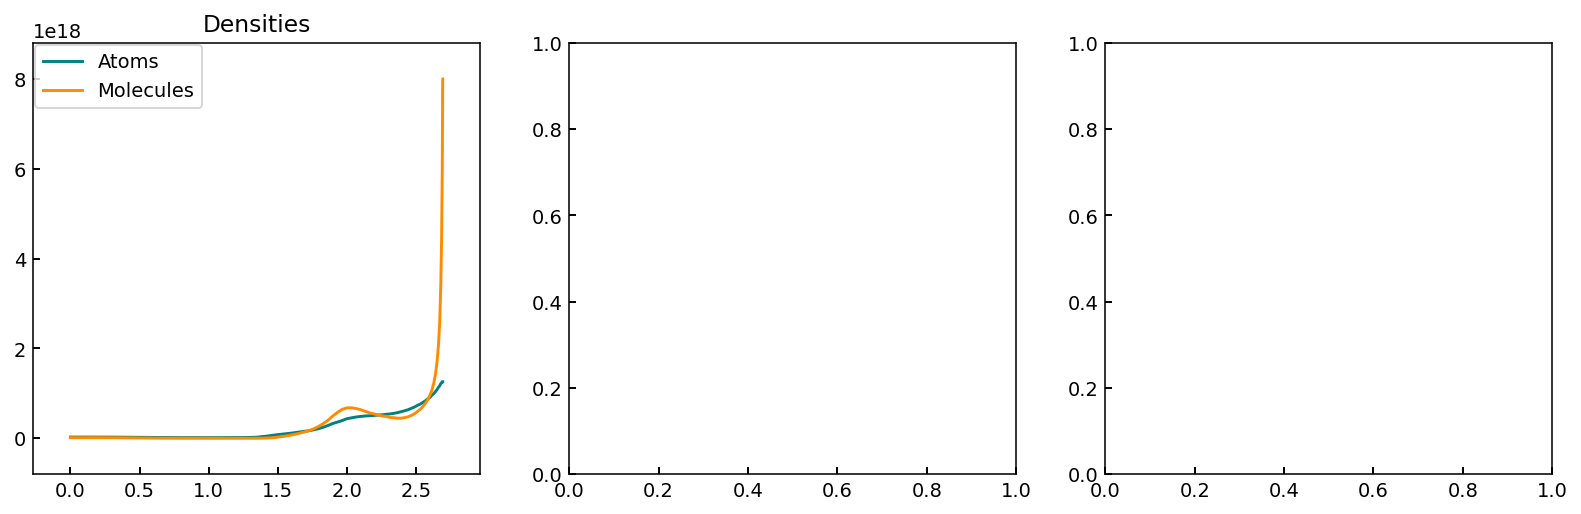

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (14,4))

ax = axes[0]
ax.set_title("Densities")
ax.plot(fl["Spol"], fl["Na"], label = "Atoms")
ax.plot(fl["Spol"], fl["Nm"], label = "Molecules")

ax = axes[1]
ax.set_title("Pressures")
ax.plot(fl["Spol"], fl["Pa"], label = "Atoms")
ax.plot(fl["Spol"], fl["Pm"], label = "Molecules")

ax.legend()

(-2.3, 0.1)

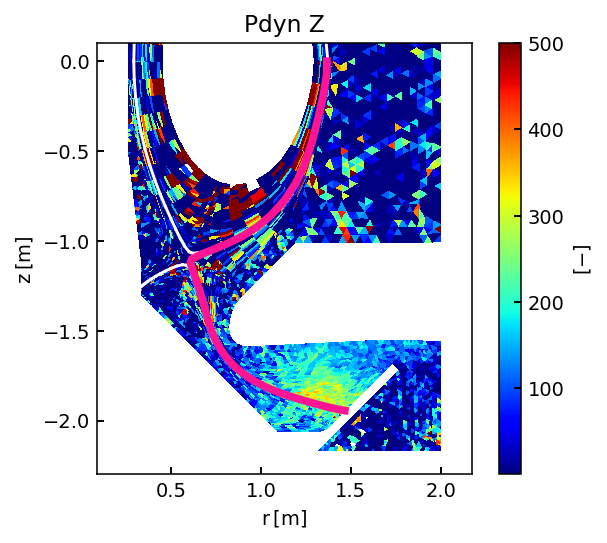

In [ ]:

fig, ax = plt.subplots()


ax.set_aspect("equal")

with HiddenPrints():
    plot_2d(fig = fig, ax = ax, scale = "linear", where = [path], species = ["D"], what = ["vxdena"],
                    vmin = vmin, vmax = vmax, value_override = Pdynz, separatrix = False)
    
ax.plot(fl["R"], fl["Z"], label = "SOLPS", c = "deeppink", lw = 4)
ax.set_title("Pdyn Z")
ax.set_ylim(-2.3, 0.1)
# fl

In [85]:
triangulation.triangles.shape

(20081, 3)

In [90]:
weighted_node_values.shape

(10488,)

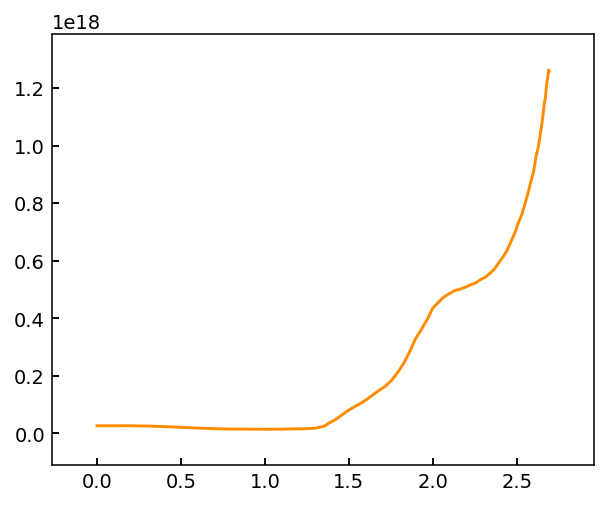

In [ ]:


fig, ax =plt.subplots()
ax.plot(fl["Spol"], fl["Nn_interp"])
ax.plot(fl["Spol"], fl["Na"])



In [29]:
data.shape

(20081,)

In [22]:
nodes

array([[ 2.        , -0.0479524 ],
       [ 2.        ,  0.        ],
       [ 2.        ,  0.0479524 ],
       ...,
       [ 1.67199822, -1.73450632],
       [ 1.67522951, -1.73477049],
       [ 1.68962371,  1.72041176]])

In [21]:
nodes[:,0].shape

(10488,)

In [20]:
cells[5,:]

array([1080, 1081, 1082])

In [126]:
fort46["vol"].shape

KeyError: 'vol'

In [30]:
def map_to_SOLPS_grid(data, key, solps = {}, is_uedge = False):

	from raysect.core.math.function.float import Discrete2DMesh

	if is_uedge:
		(triangle_data, vertex_coords, triangles) = to_triangles(nsp = 1, vs = data[key], b2fgmtry = data["b2fgmtry"])
	else:
		vertex_coords = data["triangles"]["nodes"]
		triangles = data["triangles"]["cells"]
		triangle_data = data[key]

	if len(triangle_data.shape) == 1: triangle_data = np.reshape(triangle_data, (triangle_data.shape[0],1))

	f2d = Discrete2DMesh(vertex_coords = vertex_coords,
						 triangles = triangles,
						 triangle_data = np.reshape(triangle_data, (triangle_data.shape[0],)),
						 limit = False, default_value = 0.0)
 
map_to_SOLPS_grid(fort46, "Pdynx")

ModuleNotFoundError: No module named 'raysect'

In [ ]:

 
def to_triangles(nsp = None, vs = None, b2fgmtry = None, is_SOLEDGE = False):

	"""

	to_triangles create a triangulation starting from the quadrangular
	B2 mesh (to simplify plotting and homogenise with plot_eirene)

	From each B2 quadrangle, 2 triangles are obtained (EIRENE-mesh-like)
	=> each value in the quadrangular cell centre must be duplicated

	# Author: Matteo Moscheni
    # E-mail: matteo.moscheni@tokamakenergy.co.uk
    # February 2022

	"""

	if not is_SOLEDGE:

		cells = []
		nodes = []
		value = []
		inode = 0

		for ix in range(b2fgmtry['nx']):
			for iy in range(b2fgmtry['ny']):

				# first triangle

				nodes += [[b2fgmtry['crx'][ix,iy,1], b2fgmtry['cry'][ix,iy,1]]]
				nodes += [[b2fgmtry['crx'][ix,iy,3], b2fgmtry['cry'][ix,iy,3]]]
				nodes += [[b2fgmtry['crx'][ix,iy,2], b2fgmtry['cry'][ix,iy,2]]]

				cells += [[inode, inode + 1, inode + 2]]

				inode += 3

				# second triangle

				nodes += [[b2fgmtry['crx'][ix,iy,2], b2fgmtry['cry'][ix,iy,2]]]
				nodes += [[b2fgmtry['crx'][ix,iy,0], b2fgmtry['cry'][ix,iy,0]]]
				nodes += [[b2fgmtry['crx'][ix,iy,1], b2fgmtry['cry'][ix,iy,1]]]

				cells += [[inode, inode + 1, inode + 2]]

				inode += 3

				# duplicate values

				if nsp > 1:
					add = np.zeros(nsp)
					for isp in range(vs.shape[2]):
						add[isp] = vs[ix,iy,isp]
					value += [add]
					value += [add] # 2 triangles in 1 quadrangle
				else:
					value += [vs[ix,iy]]
					value += [vs[ix,iy]] # 2 triangles in 1 quadrangle

In [23]:
path = r"C:\Users\Mike\OneDrive\Project\lot2_2d\Moulton MAST-U SOLPS runs\45456-Dec1523-seq-23\puff=1.5e21_pump=0.001_nodrifts_bcmom2_parmvsa2_redoutpfrtrans"

vars = []
with open(os.path.join(path,"fort.44"), "r") as f:
    for line in f:
        if "*eirene data field" in line:
            vars.append(line.split()[3])
            
            


In [25]:
[print(x) for x in vars if "VX" in x]

[]

In [48]:
fort46 = read_ft46(where = path)


read_ft46: -- file version 20170930


In [67]:

from solps_python_scripts.solps_plot import PlotSolps2D

fig, ax = plt.subplots()
PlotSolps2D(keys = ["te"], cases = [path], save = False)

b2fgmtry loaded from .pkl
b2fstate loaded from .pkl

   b2fplasmf not up-to-date!


   b2fplasmf not up-to-date!

   Generating b2fplasmf from b2fplasma...


b2fstate loaded from .pkl
fort.44 loaded from .pkl
fort.46 loaded from .pkl
read_b2wdat_iout_4...
Failed to read custom variables in read_b2wdat_iout_4


KeyError: 'b2trcl_luciani_fllim_cvsahzx001'

In [43]:
fort46["vxdena"].shape

(20081, 2)

In [ ]:
fid = open(os.path.join(path, "fort.44"), "r")

read_ft44_rfield(fid, )

fid.close()

In [10]:
hr.keys()

dict_keys(['next-base'])

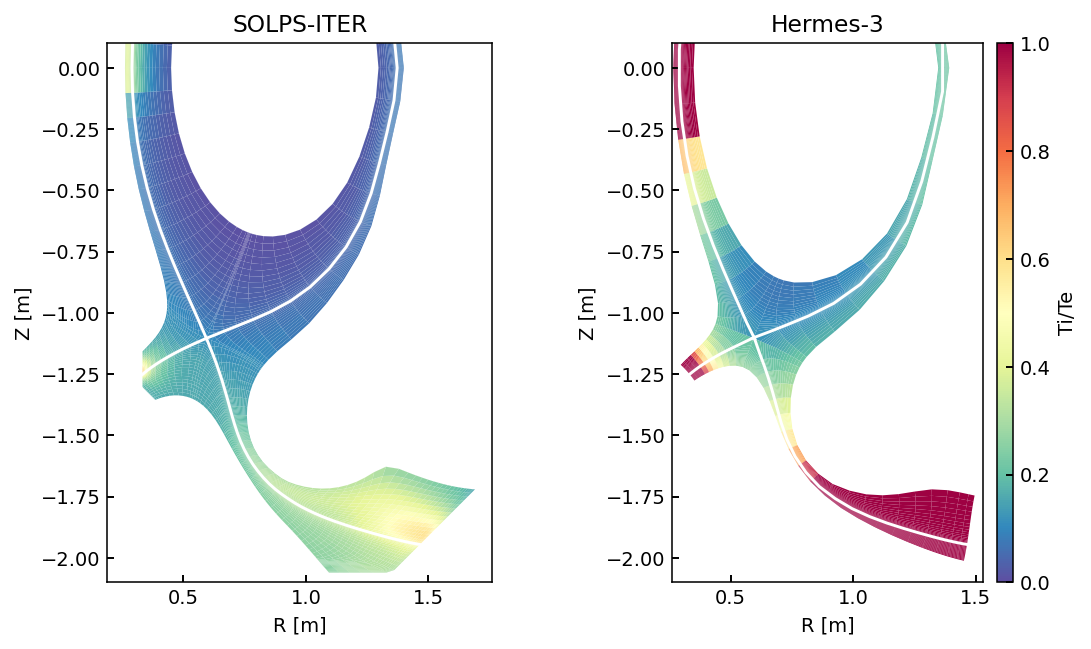

In [14]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
from hermes3.utils import create_norm
norm = create_norm(False, None, 0, 1)

## SOLPS
slc = store_slc["base"]
slc.plot_2d("Pa", norm = norm,  cbar = False, logscale = False, ax = axes[0], antialias = True)


## Hermes-3
ds = cs["next-base"].ds.isel(t=-1)
(ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", logscale = False, add_colorbar = False, norm = norm, antialias = True,
separatrix_kwargs = dict(color = "white", linestyle = "solid"), targets = False)

for ax in axes.flatten():
    # ax.set_xlim(0.2, 0.65)
    ax.set_ylim(-2.1, 0.1)
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
    
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = "Spectral_r"), cax = cax, label = "Ti/Te", extend = "neither")
    
axes[0].set_title("SOLPS-ITER")
# axes[1].set_title("SOLEDGE2D")
axes[1].set_title("Hermes-3")
fig.subplots_adjust(wspace = 0)